In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_array
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data

from cci.utils import get_adata
from cci.data import dataset_application_poster, save_application_experiment, load_application_experiment
from cci.models import MultilayerNode2Vec

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "

In [2]:
case = "distance"

with timebudget("loading data"):
    data, df, graph_hparams = dataset_application_poster(case = case)

loading data took 7.275sec


In [3]:
# MultilayerNode2vec hyperparameters
n2v_params = dict(p=1.0, 
                q=1.0, 
                embedding_dim=15,
                walk_length=10,
                context_size=10,
                walks_per_node=1,
                num_negative_samples_per_layer=1,
                num_nodes=graph_hparams["num_nodes"],
                batch_size=128)

device = "cpu"
model_dict = {}
loader_dict = {}
optimizer_dict = {}
for i in range(graph_hparams["n_layers"]):
    model_dict[i] = MultilayerNode2Vec(data.edge_index_list, **n2v_params, sparse=True).to(device)
    loader_dict[i] = model_dict[i].loader(batch_size=n2v_params['batch_size'], shuffle=True)
    optimizer_dict[i] = torch.optim.SparseAdam(list(model_dict[i].parameters()), lr=0.01)


def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def get_z(model_dict):
    z_list = [None] * len(model_dict.values())
    for i, model in enumerate(model_dict.values()):
        model.eval()
        z_list[i] = model()
        z_list[i] = z_list[i].detach().cpu().numpy()
    z = np.concatenate(z_list, axis=1)
    del z_list
    return z

@torch.no_grad()
def test(model_dict):
    z = get_z(model_dict)
    clf = LogisticRegression().fit(z[data.train_idx], data.labels[data.train_idx])
    acc_test = clf.score(z[data.test_idx], data.labels[data.test_idx])
    keep_idx = np.concatenate([data.train_idx, data.test_idx])
    acc_overall = clf.score(z[keep_idx], data.labels[keep_idx])
    return acc_test, acc_overall


def show_embeddings(z, df, savepath=None):
    if savepath is not None:
        assert savepath.endswith(".png"), "savepath should end with .png"
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_tsne = tsne.fit_transform(z)

    keep = df["participant"].values
    subclass_color_dict = df[["subclass_color", "subclass"]].drop_duplicates()
    subclass_color_dict = subclass_color_dict.set_index("subclass").to_dict()["subclass_color"] 
    f, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(x=z_tsne[keep, 0], y=z_tsne[keep, 1], hue=df["subclass"][keep], 
                    palette=subclass_color_dict, s=5, linewidth=0, ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_subclass.png"), dpi=300)
    else:
        plt.show()

    f, ax = plt.subplots(figsize=(5, 5))
    participant_color_dict = {True: "darkgrey", False: "whitesmoke"}
    sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=df["participant"], 
                    palette=participant_color_dict, s=3, linewidth=0, ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_participant.png"), dpi=300)
    else:
        plt.show()

    plt.show()
    return z_tsne

Epoch: 010, Loss: 1.5975, Test accuracy: 0.2376, Overall accuracy: 0.2535
Epoch: 020, Loss: 1.0925, Test accuracy: 0.2769, Overall accuracy: 0.2905
Epoch: 030, Loss: 0.9468, Test accuracy: 0.3051, Overall accuracy: 0.3166
Epoch: 040, Loss: 0.9021, Test accuracy: 0.3255, Overall accuracy: 0.3368
Epoch: 050, Loss: 0.8786, Test accuracy: 0.3318, Overall accuracy: 0.3469
Epoch: 060, Loss: 0.8658, Test accuracy: 0.3467, Overall accuracy: 0.3543
Epoch: 070, Loss: 0.8534, Test accuracy: 0.3537, Overall accuracy: 0.3610
Epoch: 080, Loss: 0.8478, Test accuracy: 0.3686, Overall accuracy: 0.3698
Epoch: 090, Loss: 0.8435, Test accuracy: 0.3757, Overall accuracy: 0.3751
Epoch: 100, Loss: 0.8423, Test accuracy: 0.3773, Overall accuracy: 0.3795
Epoch: 110, Loss: 0.8385, Test accuracy: 0.3725, Overall accuracy: 0.3744
Epoch: 120, Loss: 0.8391, Test accuracy: 0.3718, Overall accuracy: 0.3745
Epoch: 130, Loss: 0.8360, Test accuracy: 0.3702, Overall accuracy: 0.3775
Epoch: 140, Loss: 0.8347, Test accurac

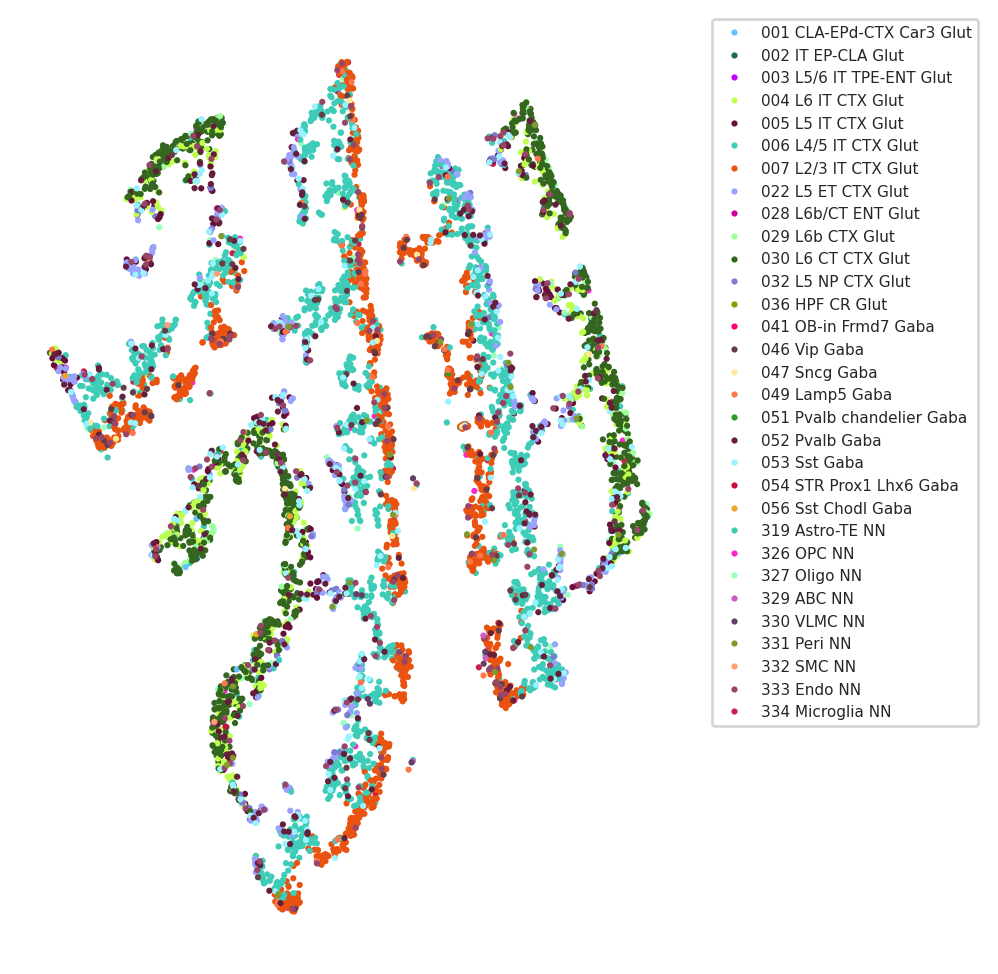

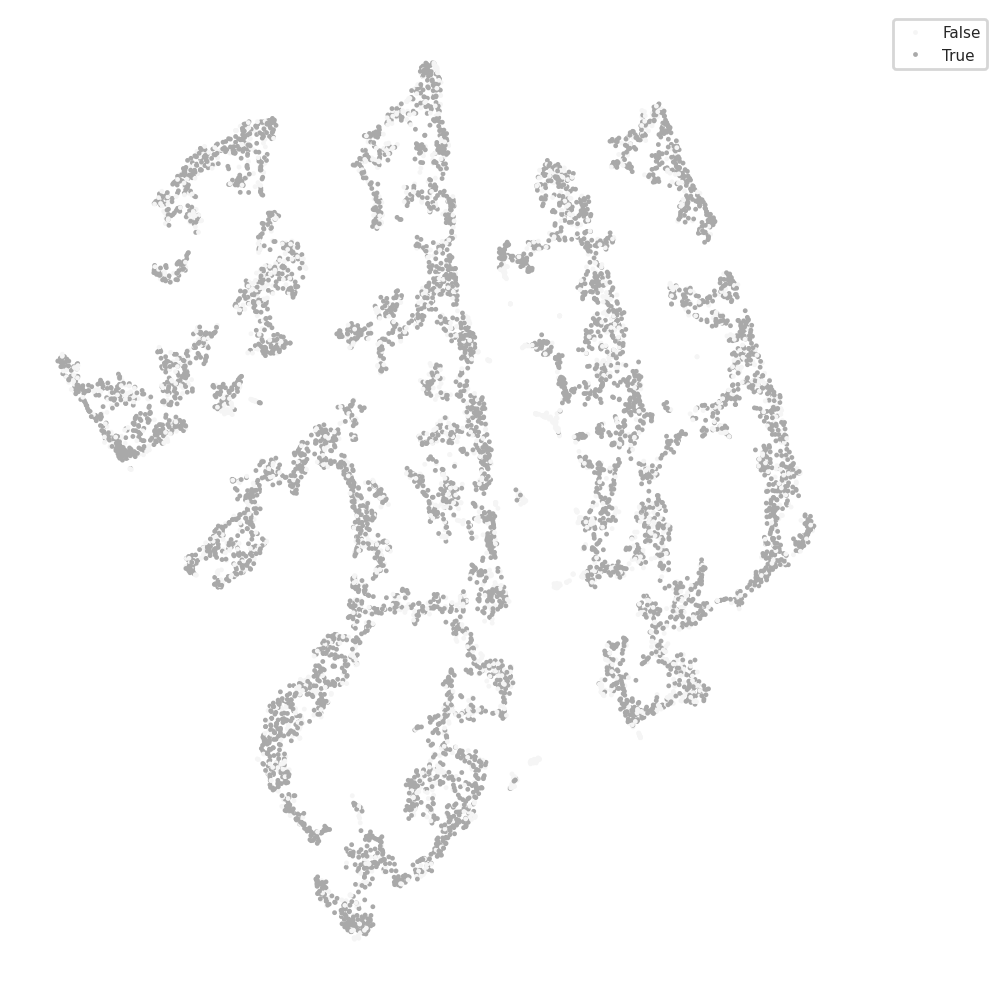

Epoch: 210, Loss: 0.8330, Test accuracy: 0.3749, Overall accuracy: 0.3772
Epoch: 220, Loss: 0.8330, Test accuracy: 0.3757, Overall accuracy: 0.3791
Epoch: 230, Loss: 0.8354, Test accuracy: 0.3725, Overall accuracy: 0.3814
Epoch: 240, Loss: 0.8300, Test accuracy: 0.3725, Overall accuracy: 0.3809
Epoch: 250, Loss: 0.8301, Test accuracy: 0.3765, Overall accuracy: 0.3784
Epoch: 260, Loss: 0.8337, Test accuracy: 0.3867, Overall accuracy: 0.3836
Epoch: 270, Loss: 0.8313, Test accuracy: 0.3780, Overall accuracy: 0.3802
Epoch: 280, Loss: 0.8314, Test accuracy: 0.3851, Overall accuracy: 0.3891
Epoch: 290, Loss: 0.8310, Test accuracy: 0.3882, Overall accuracy: 0.3872
Epoch: 300, Loss: 0.8329, Test accuracy: 0.3953, Overall accuracy: 0.3935
Epoch: 310, Loss: 0.8298, Test accuracy: 0.3859, Overall accuracy: 0.3946
Epoch: 320, Loss: 0.8315, Test accuracy: 0.3984, Overall accuracy: 0.3995
Epoch: 330, Loss: 0.8327, Test accuracy: 0.4133, Overall accuracy: 0.3979
Epoch: 340, Loss: 0.8315, Test accurac

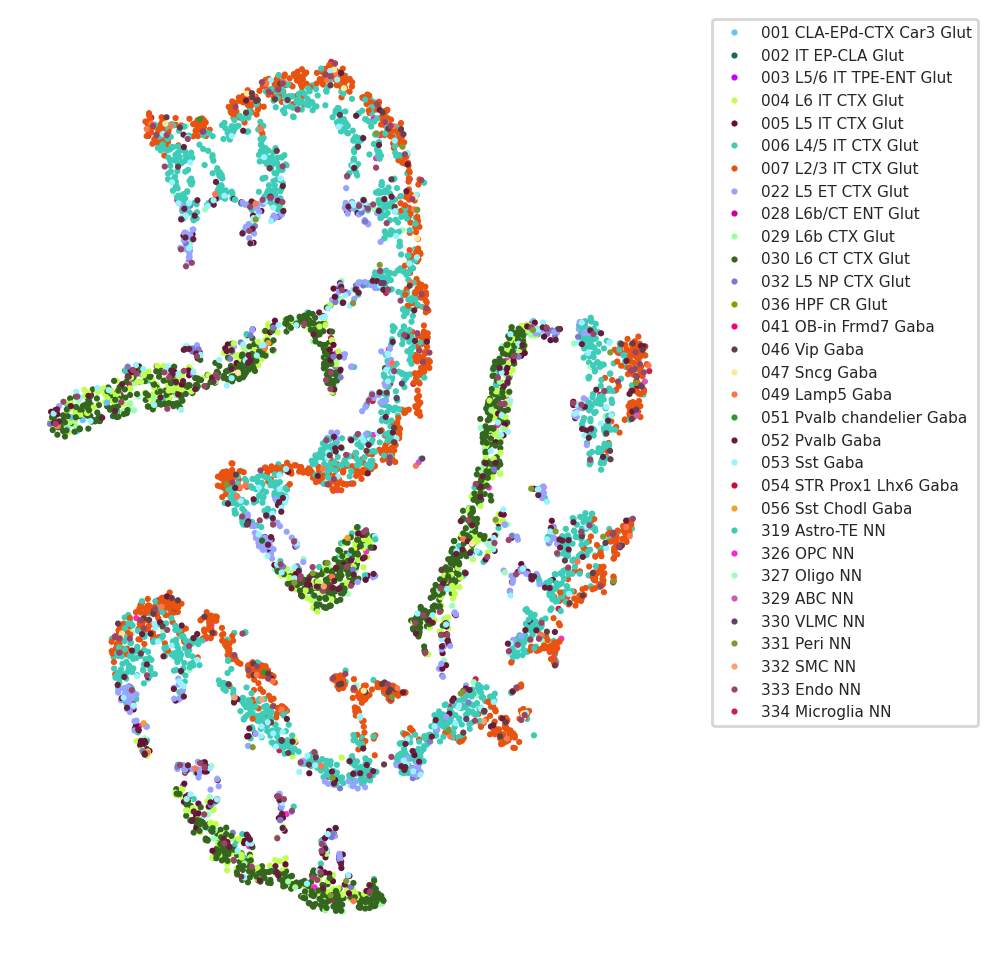

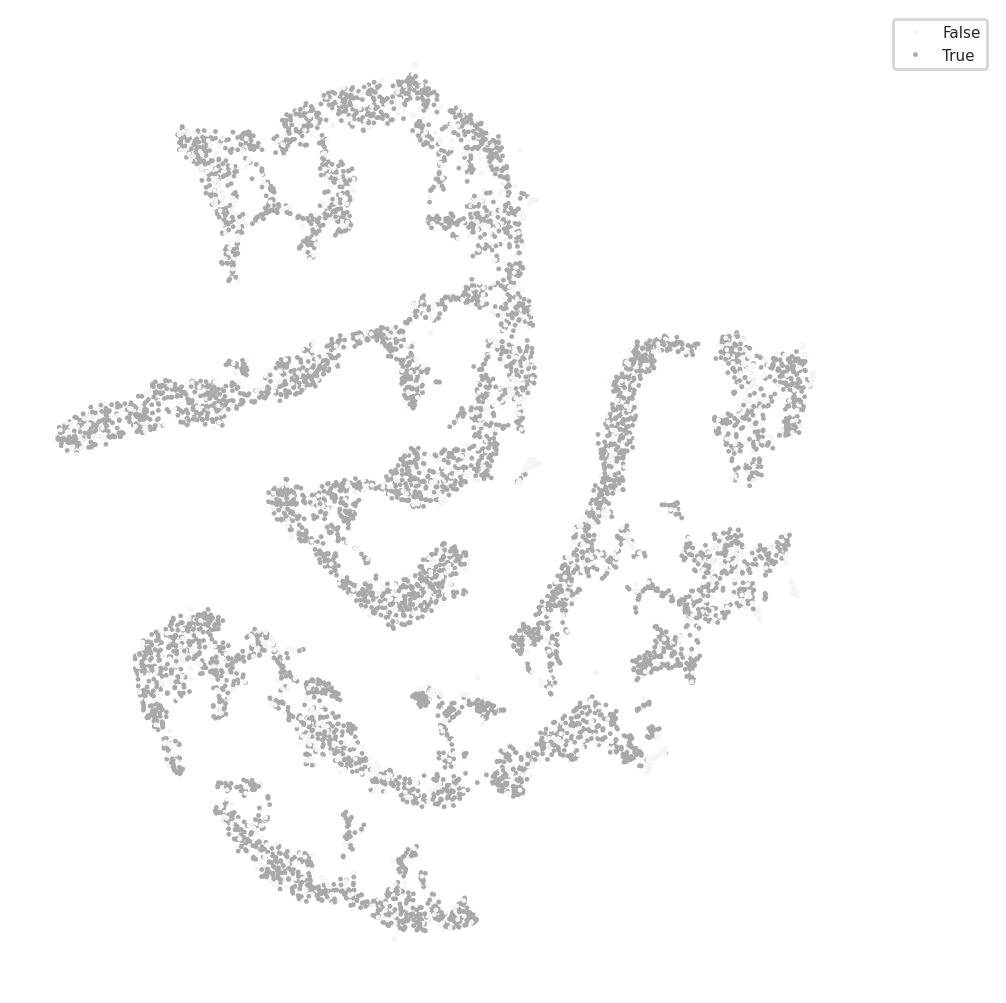

Epoch: 410, Loss: 0.8288, Test accuracy: 0.3992, Overall accuracy: 0.4007
Epoch: 420, Loss: 0.8289, Test accuracy: 0.4047, Overall accuracy: 0.4018
Epoch: 430, Loss: 0.8290, Test accuracy: 0.4071, Overall accuracy: 0.4108
Epoch: 440, Loss: 0.8305, Test accuracy: 0.4173, Overall accuracy: 0.4127
Epoch: 450, Loss: 0.8239, Test accuracy: 0.4149, Overall accuracy: 0.4137
Epoch: 460, Loss: 0.8281, Test accuracy: 0.4149, Overall accuracy: 0.4141
Epoch: 470, Loss: 0.8280, Test accuracy: 0.4102, Overall accuracy: 0.4133
Epoch: 480, Loss: 0.8262, Test accuracy: 0.4235, Overall accuracy: 0.4131
Epoch: 490, Loss: 0.8275, Test accuracy: 0.4157, Overall accuracy: 0.4123
Epoch: 500, Loss: 0.8308, Test accuracy: 0.4188, Overall accuracy: 0.4122
Epoch: 510, Loss: 0.8273, Test accuracy: 0.4196, Overall accuracy: 0.4083
Epoch: 520, Loss: 0.8265, Test accuracy: 0.4110, Overall accuracy: 0.4119
Epoch: 530, Loss: 0.8246, Test accuracy: 0.4196, Overall accuracy: 0.4087
Epoch: 540, Loss: 0.8255, Test accurac

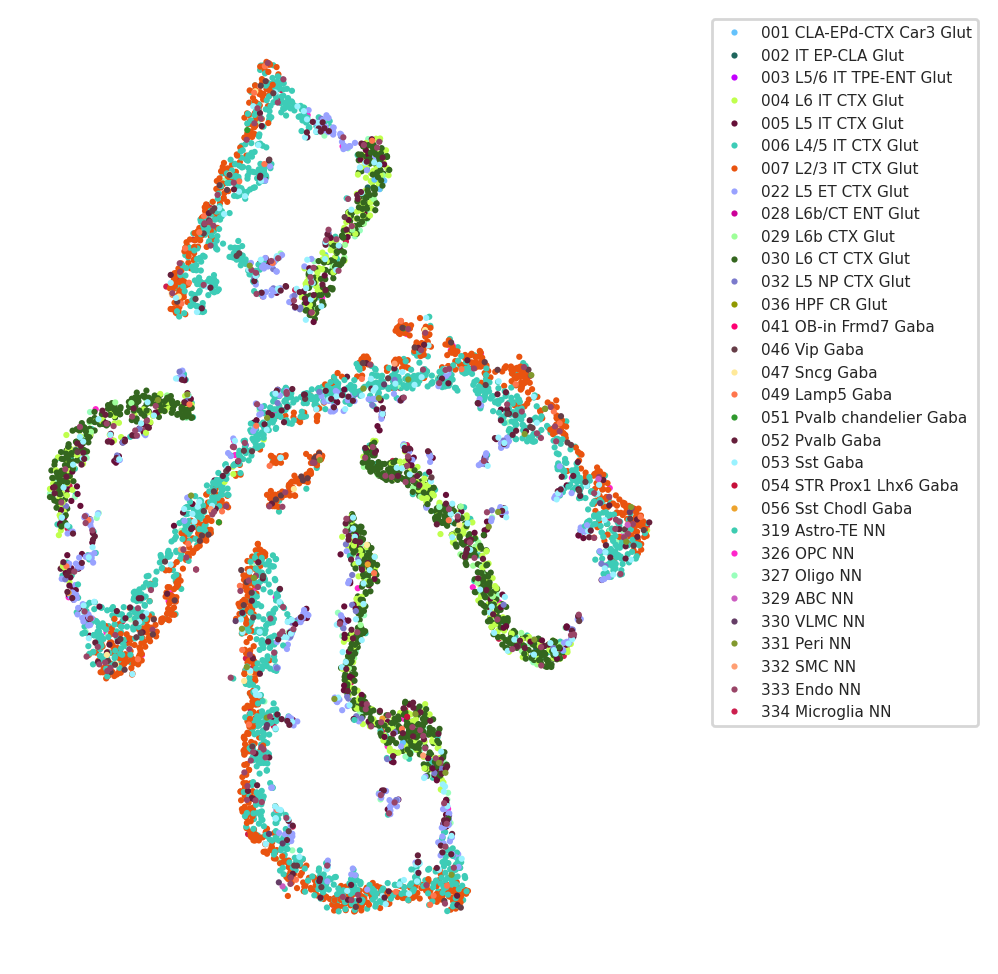

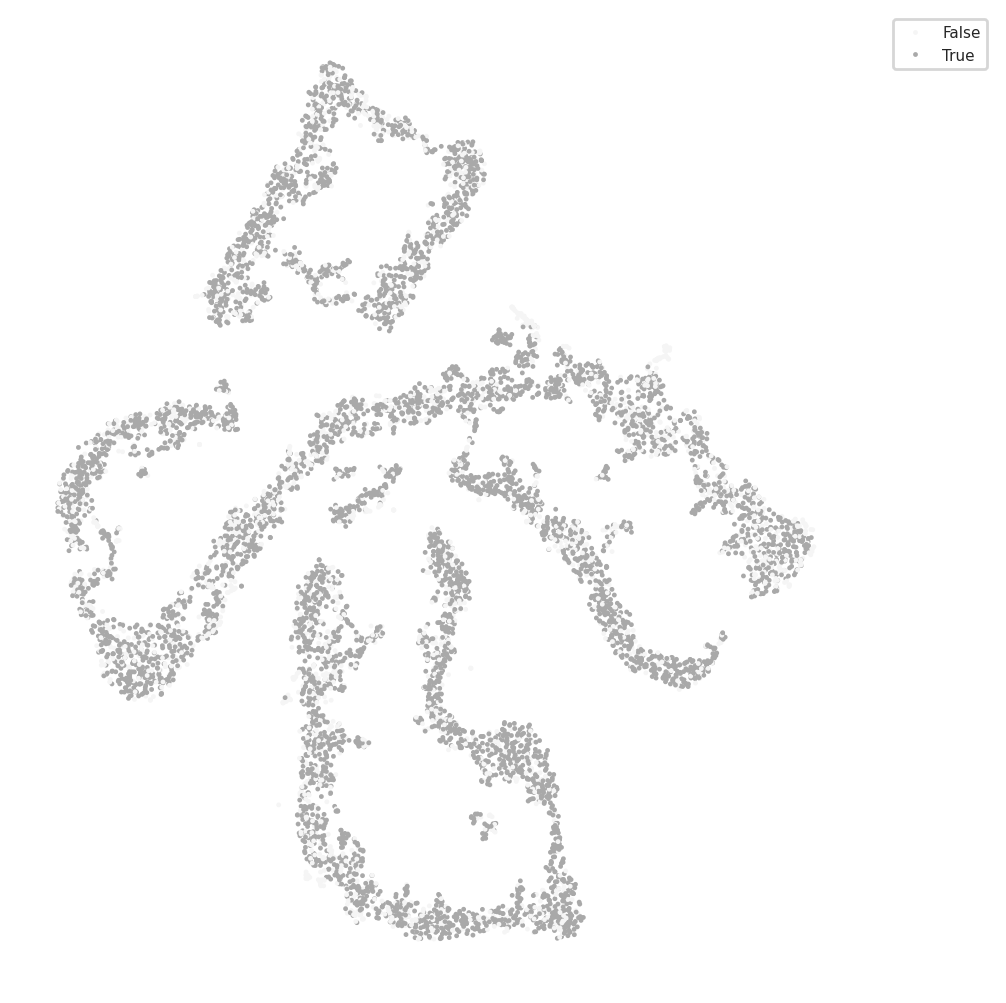

Epoch: 610, Loss: 0.8293, Test accuracy: 0.4094, Overall accuracy: 0.4208
Epoch: 620, Loss: 0.8277, Test accuracy: 0.4031, Overall accuracy: 0.4087
Epoch: 630, Loss: 0.8282, Test accuracy: 0.4165, Overall accuracy: 0.4186
Epoch: 640, Loss: 0.8265, Test accuracy: 0.4039, Overall accuracy: 0.4114
Epoch: 650, Loss: 0.8267, Test accuracy: 0.4118, Overall accuracy: 0.4116
Epoch: 660, Loss: 0.8292, Test accuracy: 0.4102, Overall accuracy: 0.4158
Epoch: 670, Loss: 0.8258, Test accuracy: 0.4157, Overall accuracy: 0.4192
Epoch: 680, Loss: 0.8237, Test accuracy: 0.4055, Overall accuracy: 0.4153
Epoch: 690, Loss: 0.8277, Test accuracy: 0.4243, Overall accuracy: 0.4216
Epoch: 700, Loss: 0.8276, Test accuracy: 0.4133, Overall accuracy: 0.4150
Epoch: 710, Loss: 0.8255, Test accuracy: 0.4125, Overall accuracy: 0.4164
Epoch: 720, Loss: 0.8219, Test accuracy: 0.4173, Overall accuracy: 0.4189
Epoch: 730, Loss: 0.8236, Test accuracy: 0.4204, Overall accuracy: 0.4229
Epoch: 740, Loss: 0.8261, Test accurac

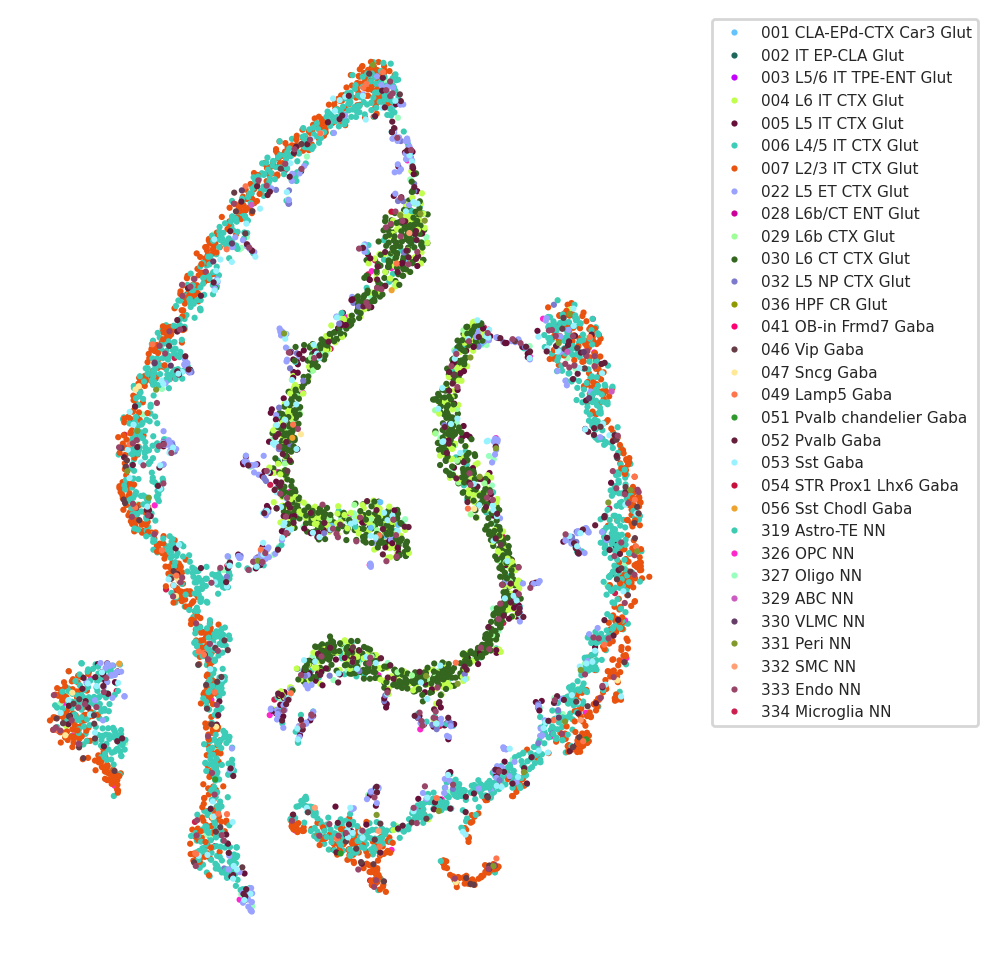

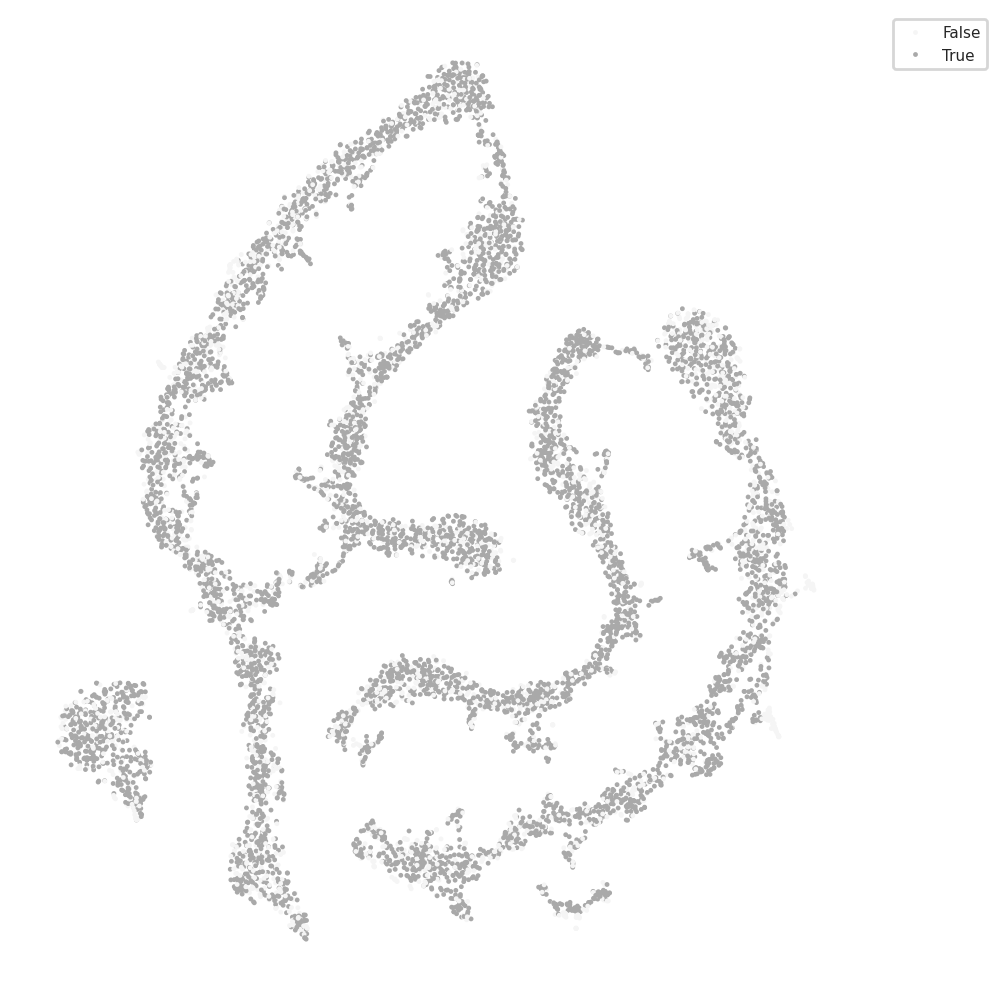

Epoch: 810, Loss: 0.8219, Test accuracy: 0.4282, Overall accuracy: 0.4249
Epoch: 820, Loss: 0.8225, Test accuracy: 0.4306, Overall accuracy: 0.4272
Epoch: 830, Loss: 0.8231, Test accuracy: 0.4259, Overall accuracy: 0.4257
Epoch: 840, Loss: 0.8235, Test accuracy: 0.4235, Overall accuracy: 0.4240
Epoch: 850, Loss: 0.8261, Test accuracy: 0.4361, Overall accuracy: 0.4283
Epoch: 860, Loss: 0.8254, Test accuracy: 0.4267, Overall accuracy: 0.4269
Epoch: 870, Loss: 0.8275, Test accuracy: 0.4196, Overall accuracy: 0.4254
Epoch: 880, Loss: 0.8251, Test accuracy: 0.4110, Overall accuracy: 0.4205
Epoch: 890, Loss: 0.8224, Test accuracy: 0.4180, Overall accuracy: 0.4225
Epoch: 900, Loss: 0.8242, Test accuracy: 0.4306, Overall accuracy: 0.4208
Epoch: 910, Loss: 0.8250, Test accuracy: 0.4196, Overall accuracy: 0.4252
Epoch: 920, Loss: 0.8236, Test accuracy: 0.4227, Overall accuracy: 0.4238
Epoch: 930, Loss: 0.8240, Test accuracy: 0.4165, Overall accuracy: 0.4279
Epoch: 940, Loss: 0.8246, Test accurac

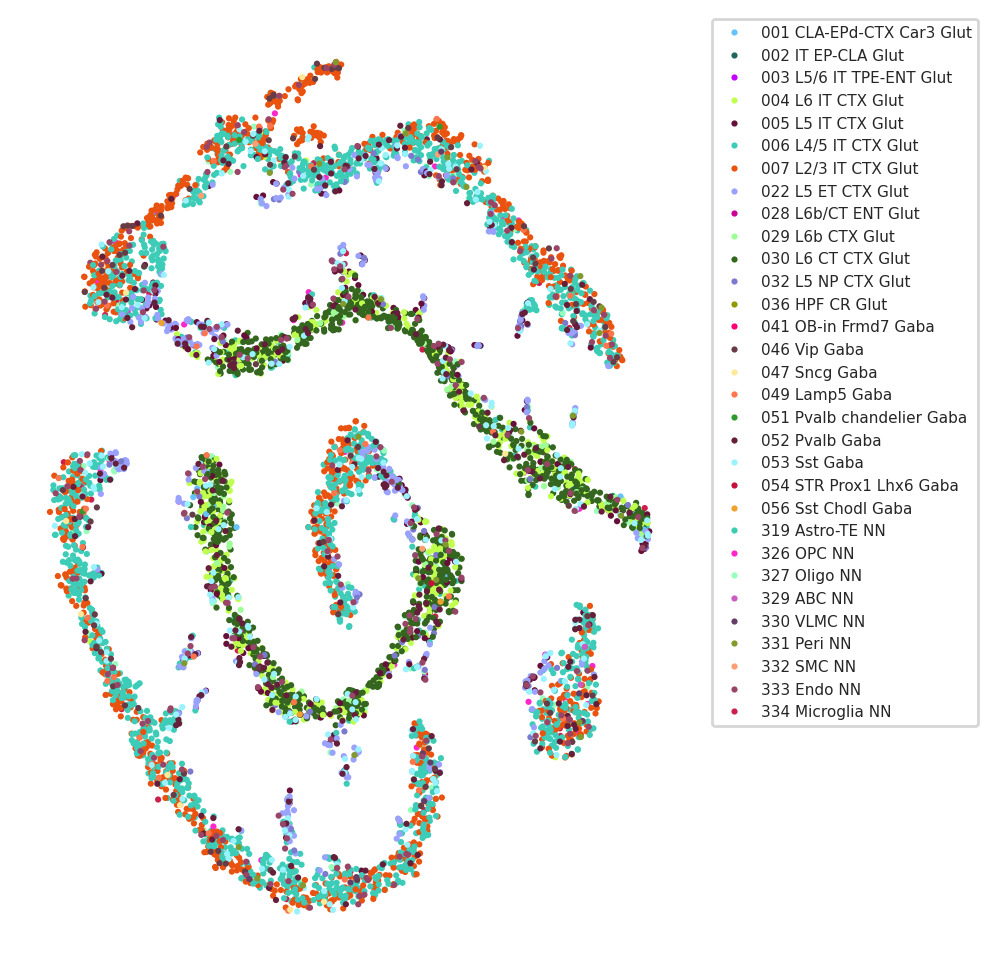

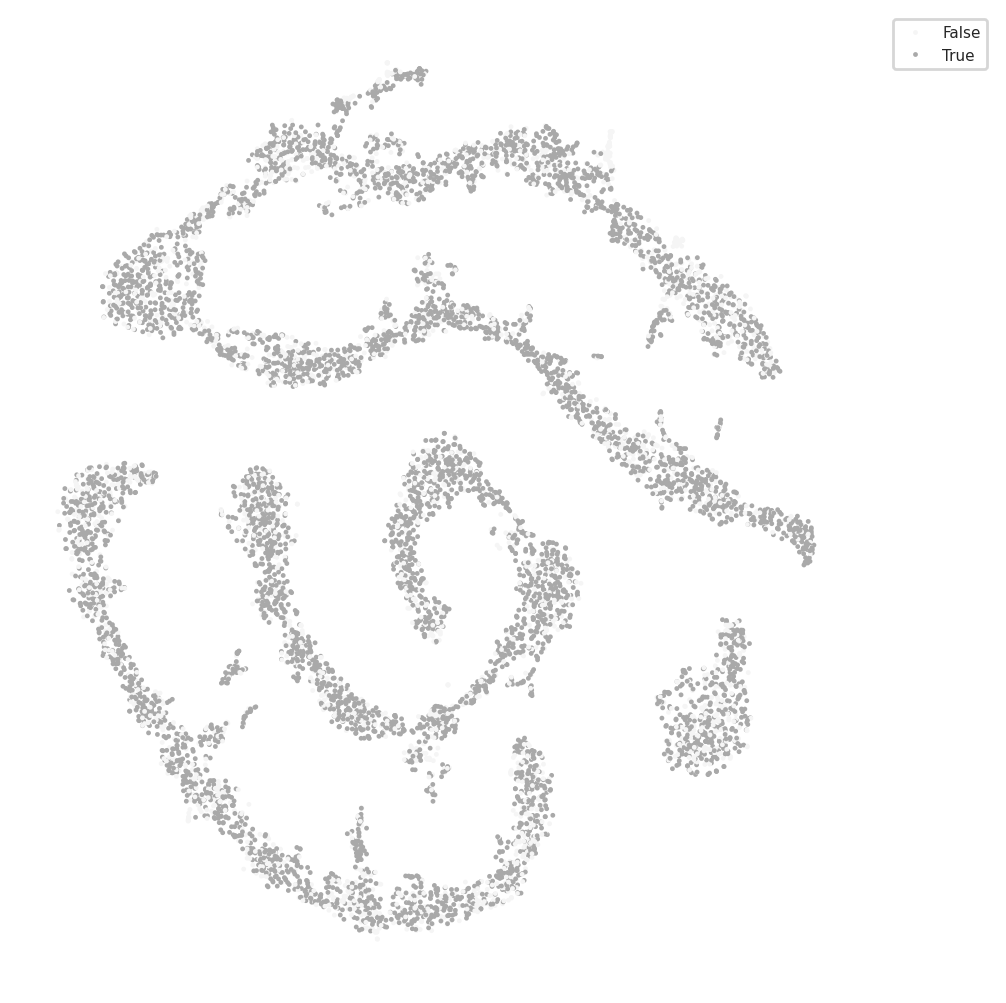

In [4]:
# model training:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    loss = [None] * graph_hparams["n_layers"]
    for i in range(graph_hparams["n_layers"]):
        loss[i] = train(model_dict[i], loader_dict[i], optimizer_dict[i])
    loss = sum(loss)

    if epoch % 10 == 0:
        acc_test, acc_overall = test(model_dict)
        print(
            f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test accuracy: {acc_test:.4f}, Overall accuracy: {acc_overall:.4f}"
        )
    if epoch % 200 == 0:
        print(f"Epoch: {epoch:03d} embeddings")
        z = get_z(model_dict)
        z_tsne = show_embeddings(z, df)
        fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
        save_application_experiment(fname=fname, 
                                    epoch=epoch, 
                                    z=z, 
                                    df=df, 
                                    graph_hparams=graph_hparams, 
                                    leiden_partitions=None, 
                                    z_tsne=z_tsne)


In [5]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph

100%|██████████| 6371/6371 [00:26<00:00, 243.55it/s]


Found 24 partitions


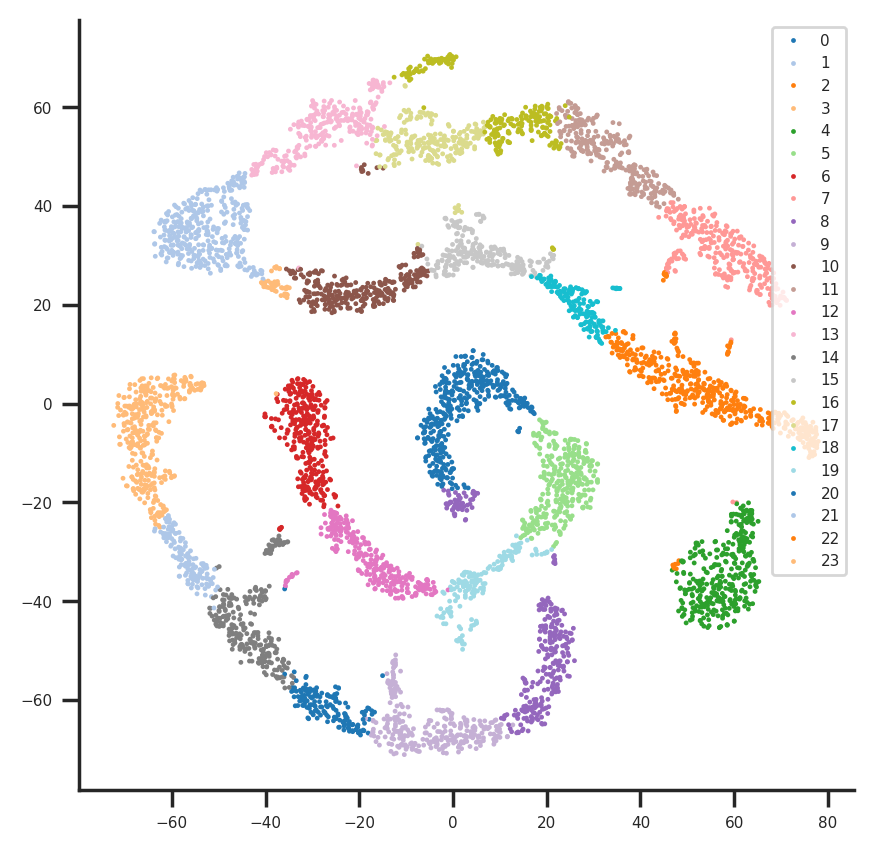

In [6]:

keep = df["participant"].values

# create a knn graph with z as positions
knn_graph = kneighbors_graph(z[keep], n_neighbors=5, mode="connectivity", include_self=False)

# convert to igraph
g = ig.Graph(directed=False)
g.add_vertices(knn_graph.shape[0])

for i in tqdm(range(knn_graph.shape[0])):
    for j in knn_graph[i].indices:
        g.add_edge(i, j)

# run leiden community detection
partition = la.find_partition(g, la.ModularityVertexPartition)
n_partitions = np.unique(partition.membership).size
print(f"Found {n_partitions} partitions")

# project labels on tsne
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=z_tsne[keep, 0], y=z_tsne[keep, 1], hue=partition.membership, palette="tab20", s=3, linewidth=0, ax=ax)
plt.show()

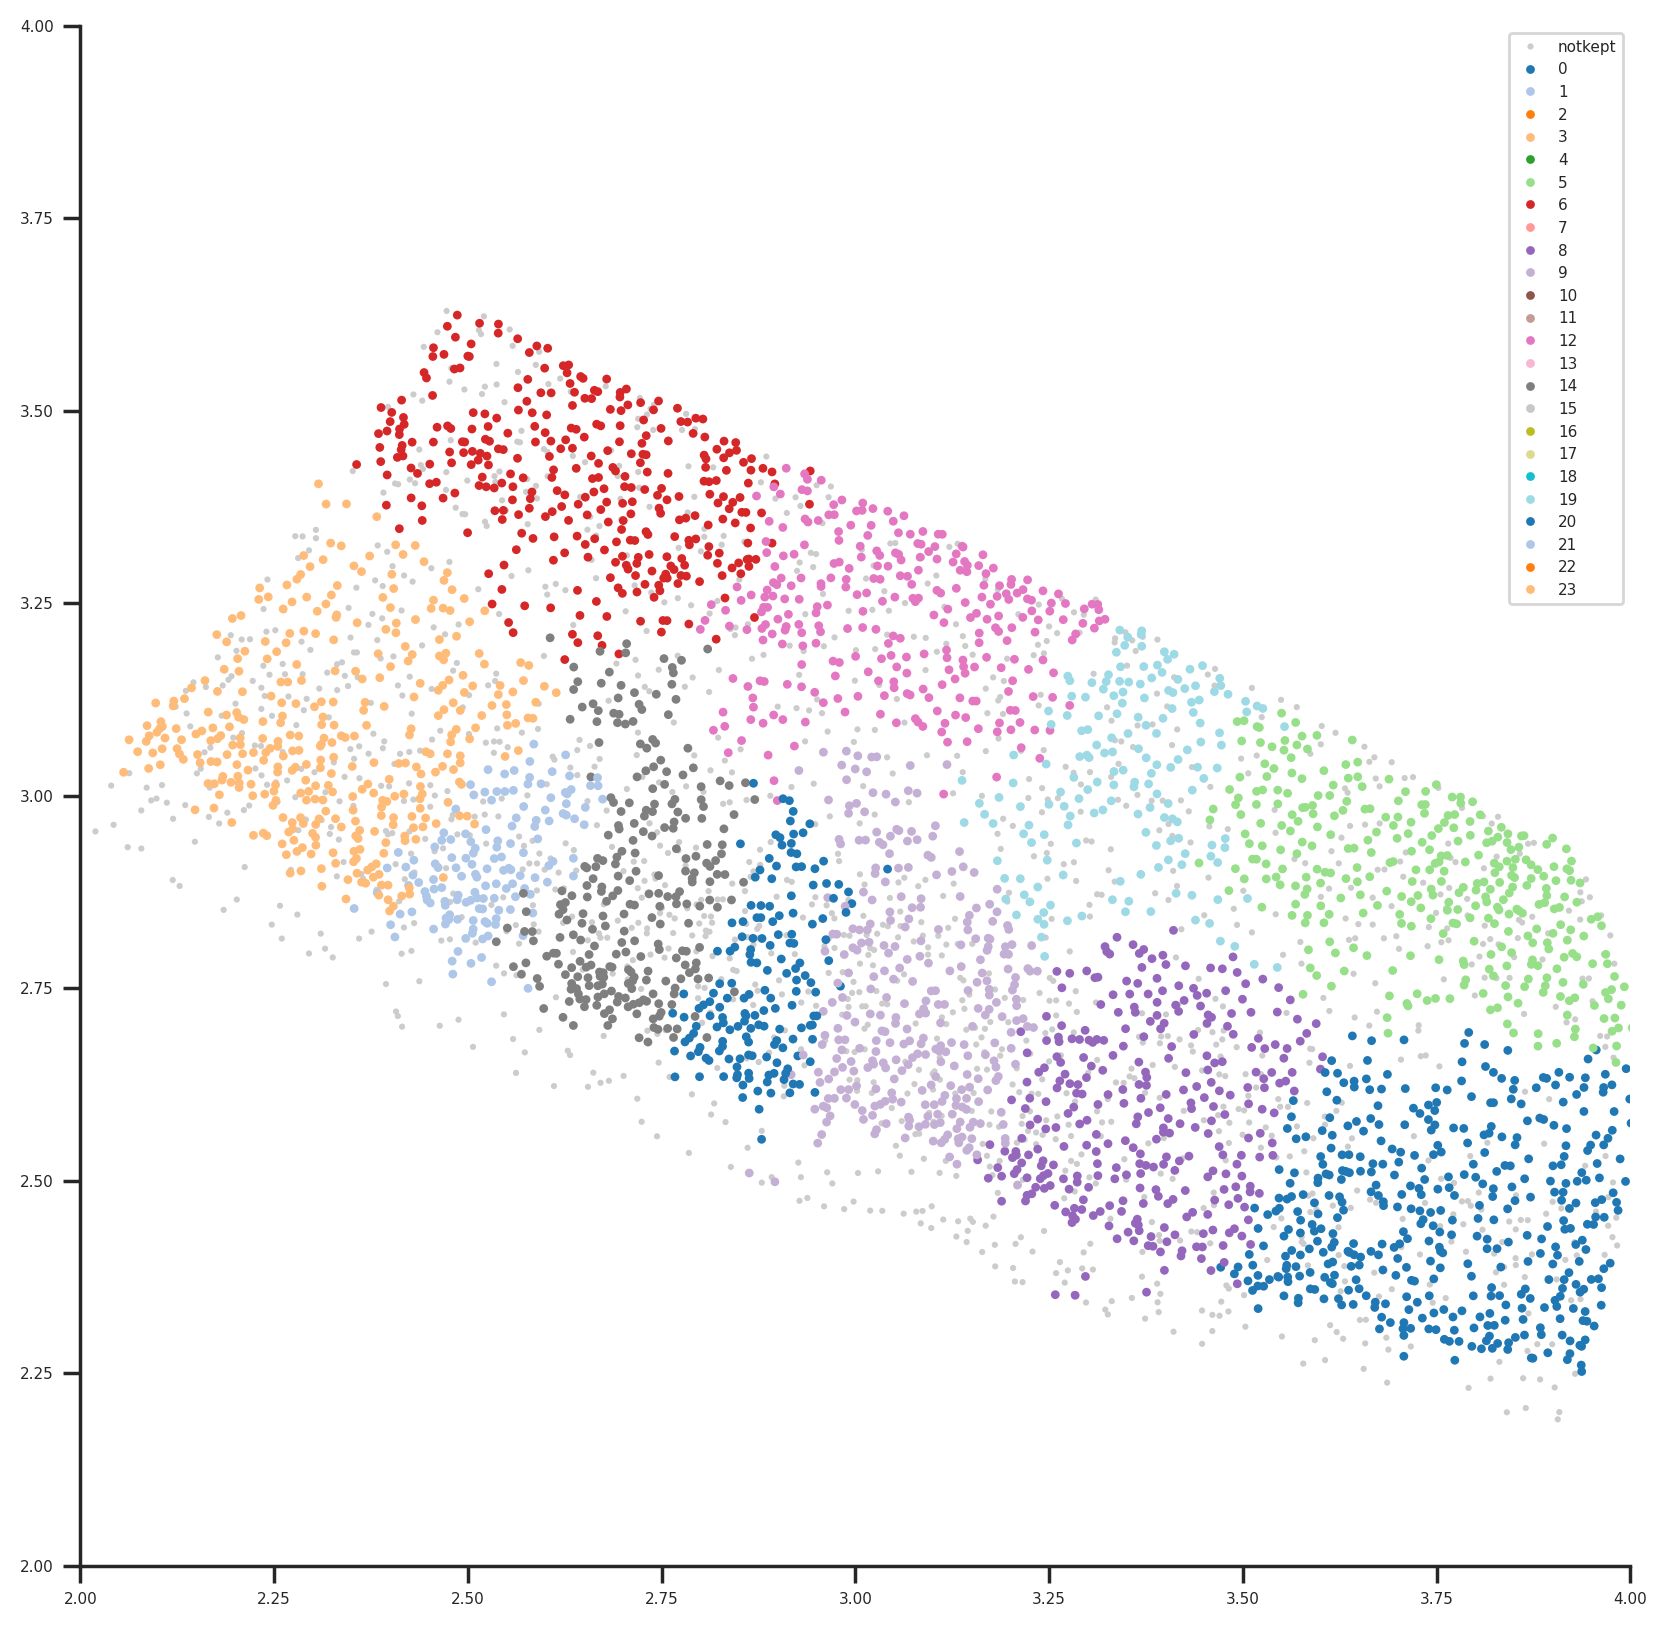

In [7]:
# project labels on brain co-ordinates
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=df["x_reconstructed"].values[~keep], 
                y=df["y_reconstructed"].values[~keep], 
                hue=np.array(["notkept"]*np.sum(~keep)),
                s=5, linewidth=0, ax=ax, palette=dict(notkept="#cccccc"))
sns.scatterplot(x=df["x_reconstructed"].values[keep], 
                y=df["y_reconstructed"].values[keep], 
                hue=partition.membership, palette="tab20", 
                s=10, linewidth=0, ax=ax)
ax.set(ylim = (2, 4), xlim = (2, 4))
plt.show()

fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
save_application_experiment(fname=fname, 
                            epoch=epoch, 
                            z=z, 
                            df=df, 
                            graph_hparams=graph_hparams,
                            n2v_params=n2v_params,
                            leiden_partitions=partition.membership,
                            z_tsne=z_tsne)